--> Loading data...
Data loaded successfully.
--> Cleaning data...
Data cleaned. Shape after cleaning: (85919, 14)
--> Engineering features...
Features engineered: 'hour_of_day', 'day_of_week', 'month', 'is_weekend'.
--> Performing EDA and generating plots...


C:\Users\neera\AppData\Local\Temp\ipykernel_5764\375564039.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='hour_of_day', palette='viridis')


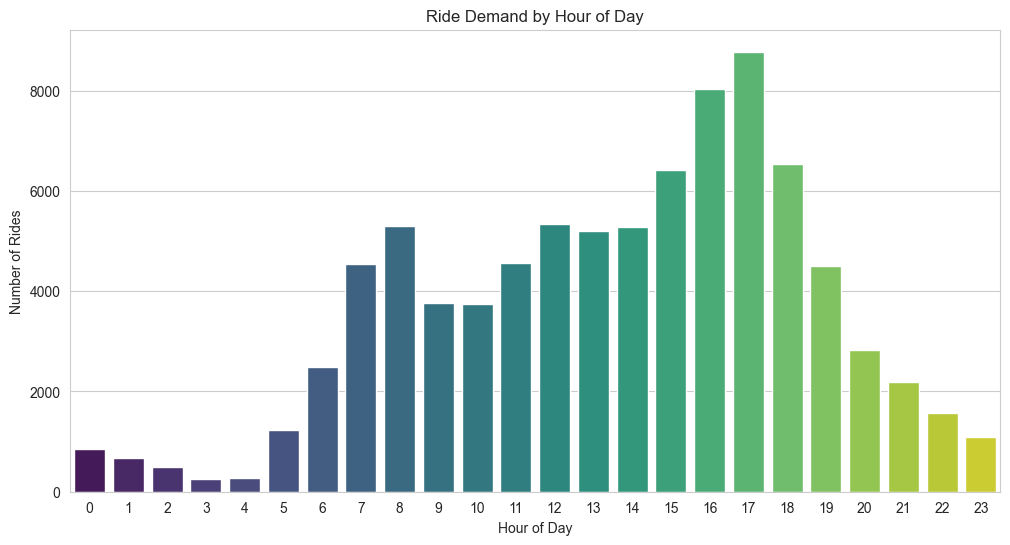

C:\Users\neera\AppData\Local\Temp\ipykernel_5764\375564039.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='day_of_week', order=day_order, palette='magma')


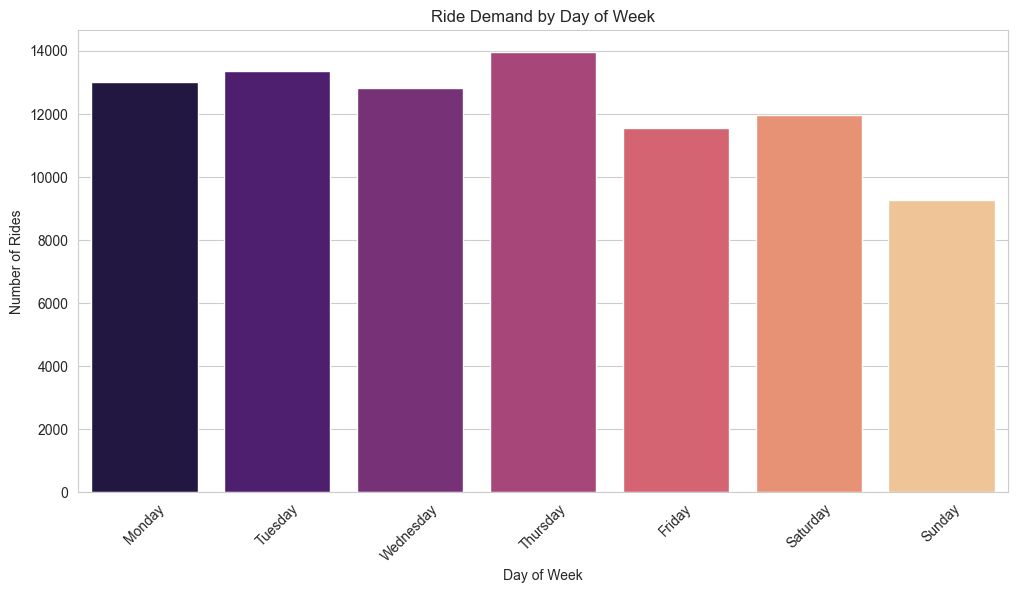

--> Aggregating data for demand prediction...
Data aggregated successfully. Sample:
    start_station_name        date  hour  ride_count
0  2112 W Peterson Ave  2022-01-01    20           1
1  2112 W Peterson Ave  2022-01-03    18           1
2  2112 W Peterson Ave  2022-01-04    10           1
3  2112 W Peterson Ave  2022-01-04    17           1
4  2112 W Peterson Ave  2022-01-10     8           1
--> Preparing data for modeling...
--> Training RandomForestRegressor model...
--> Evaluating model...
Model Training Complete. Root Mean Squared Error (RMSE): 0.7650
--> Saving the model to file...
Model successfully saved to '../output/demand_forecast_model.pkl'.

--- SCRIPT FINISHED ---


In [2]:
# =============================================================================
# 1. SETUP AND IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Set plot style for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


# =============================================================================
# 2. DATA LOADING AND CLEANING
# =============================================================================
print("--> Loading data...")
# Make sure to change the filename to match the one you downloaded
# If you have multiple files, you can load and concatenate them here
try:
    df = pd.read_csv('../data/Divvy_Trips_2022_Q1.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset not found. Make sure the CSV file is in the 'data/' folder.")
    exit() # Exit the script if the file is not found

print("--> Cleaning data...")
# Convert to datetime objects for time-based calculations
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])

# Calculate ride duration in seconds
df['duration_sec'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

# Handle missing station names, which are crucial for our analysis
df.dropna(subset=['start_station_name'], inplace=True)

# Filter out outliers: trips less than 60 seconds or more than 3 hours
df = df[(df['duration_sec'] > 60) & (df['duration_sec'] < 10800)]
print(f"Data cleaned. Shape after cleaning: {df.shape}")


# =============================================================================
# 3. FEATURE ENGINEERING
# =============================================================================
print("--> Engineering features...")
df['hour_of_day'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.day_name()
df['month'] = df['started_at'].dt.month
df['is_weekend'] = df['started_at'].dt.dayofweek >= 5
print("Features engineered: 'hour_of_day', 'day_of_week', 'month', 'is_weekend'.")


# =============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
print("--> Performing EDA and generating plots...")

# Plot 1: Ride demand by hour of the day
plt.figure()
sns.countplot(data=df, x='hour_of_day', palette='viridis')
plt.title('Ride Demand by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.savefig('../output/rides_by_hour.png')
plt.show()

# Plot 2: Ride demand by day of the week
plt.figure()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='day_of_week', order=day_order, palette='magma')
plt.title('Ride Demand by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.savefig('../output/rides_by_day.png')
plt.show()


# =============================================================================
# 5. DATA AGGREGATION FOR MODELING (Corrected)
# =============================================================================
print("--> Aggregating data for demand prediction...")

# First, create explicit 'date' and 'hour' columns in the main DataFrame
df['date'] = df['started_at'].dt.date
df['hour'] = df['started_at'].dt.hour

# Now, group by the new, clearly named columns
demand_df = df.groupby([
    'start_station_name',
    'date',
    'hour'
]).size().reset_index(name='ride_count')

print("Data aggregated successfully. Sample:")
print(demand_df.head())


# =============================================================================
# 6. MODEL TRAINING AND EVALUATION
# =============================================================================
print("--> Preparing data for modeling...")

# Create features for the model from the aggregated data
demand_df['date'] = pd.to_datetime(demand_df['date'])
demand_df['day_of_week_num'] = demand_df['date'].dt.dayofweek
demand_df['is_weekend'] = (demand_df['day_of_week_num'] >= 5).astype(int)

# One-hot encode the station names to be used as a feature
features_df = pd.get_dummies(demand_df, columns=['start_station_name'])

# Define features (X) and target (y)
X = features_df.drop(['ride_count', 'date'], axis=1)
y = features_df['ride_count']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"--> Training RandomForestRegressor model...")
# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
model.fit(X_train, y_train)

print("--> Evaluating model...")
# Make predictions and evaluate performance
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Model Training Complete. Root Mean Squared Error (RMSE): {rmse:.4f}")


# =============================================================================
# 7. SAVE THE TRAINED MODEL
# =============================================================================
print("--> Saving the model to file...")
model_filename = '../output/demand_forecast_model.pkl'
joblib.dump(model, model_filename)
print(f"Model successfully saved to '{model_filename}'.")
print("\n--- SCRIPT FINISHED ---")

In [3]:
# In your Jupyter Notebook (e.g., 02_demand_modeling.ipynb)

print("--> Saving station coordinates for the app...")
# Get unique stations and their first known coordinates
station_coords = df[['start_station_name', 'start_lat', 'start_lng']].drop_duplicates(subset='start_station_name')
station_coords.rename(columns={'start_lat': 'lat', 'start_lng': 'lon'}, inplace=True)

# Save to a file in the output folder
station_coords.to_csv('../output/station_coordinates.csv', index=False)
print("Station coordinates saved successfully.")

--> Saving station coordinates for the app...
Station coordinates saved successfully.


In [4]:
# In your Jupyter Notebook, right after you define X and y

import pickle

print("--> Saving model training columns...")
# X is the feature DataFrame before splitting
model_columns = list(X.columns)
with open('../output/model_columns.pkl', 'wb') as f:
    pickle.dump(model_columns, f)
print("Model columns saved successfully.")

--> Saving model training columns...
Model columns saved successfully.


In [5]:
# app.py

import streamlit as st
import pandas as pd
import joblib
import pickle
from datetime import datetime

# =============================================================================
# LOAD ASSETS
# =============================================================================

# Use a try-except block to handle file loading
try:
    # Load the trained model
    model = joblib.load('output/demand_forecast_model.pkl')
    # Load the list of columns the model was trained on
    with open('output/model_columns.pkl', 'rb') as f:
        model_columns = pickle.load(f)
    # Load station coordinates for mapping
    stations_df = pd.read_csv('output/station_coordinates.csv')
except FileNotFoundError as e:
    st.error(f"Error loading necessary files: {e}. Please run the data preparation steps in your notebook first.")
    st.stop()


# =============================================================================
# PREDICTION FUNCTION
# =============================================================================

def make_prediction(date, hour):
    """
    Prepares input data and returns predictions for all stations.
    """
    # 1. Create a base DataFrame with all stations for the selected time
    prediction_df = stations_df.copy()
    prediction_df['hour'] = hour
    prediction_df['day_of_week_num'] = date.weekday()
    prediction_df['is_weekend'] = 1 if prediction_df['day_of_week_num'] >= 5 else 0

    # 2. One-hot encode the station names
    prediction_df = pd.get_dummies(prediction_df, columns=['start_station_name'])

    # 3. Ensure the prediction DataFrame has the exact same columns as the training data
    #    - Add any missing columns (stations not in this prediction set) and fill with 0
    #    - Order columns to match the model's expectation
    current_columns = list(prediction_df.columns)
    missing_columns = set(model_columns) - set(current_columns)
    for col in missing_columns:
        prediction_df[col] = 0
    
    # Reorder columns to match the training set exactly
    prediction_df = prediction_df[model_columns]
    
    # 4. Make predictions
    predictions = model.predict(prediction_df)
    
    # 5. Add predictions to a results DataFrame
    results_df = stations_df.copy()
    results_df['predicted_demand'] = predictions.round(2)
    
    return results_df


# =============================================================================
# USER INTERFACE
# =============================================================================

st.set_page_config(page_title="CityPulse Dashboard", layout="wide")
st.title('🚲 CityPulse: Divvy Bikes Demand Forecast')
st.write("An interactive dashboard to predict rider demand for Divvy Bike stations across Chicago.")

# --- Sidebar for User Input ---
st.sidebar.header('Prediction Parameters')
selected_date = st.sidebar.date_input("Select a Date", datetime.now())
selected_hour = st.sidebar.slider("Select an Hour of the Day", 0, 23, 17) # Default to 5 PM (17:00)

# --- Main Panel for Displaying Results ---
if st.sidebar.button('Predict Demand'):
    with st.spinner('Forecasting demand...'):
        # Get predictions
        results = make_prediction(selected_date, selected_hour)
        
        st.success(f"Prediction complete for {selected_date.strftime('%A, %B %d, %Y')} at {selected_hour}:00.")

        # Create two columns for layout
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Predicted Demand Hotspots")
            # Display map with color-coded dots based on demand
            # We add a small constant to size to make low-demand stations visible
            st.map(results,
                   latitude='lat',
                   longitude='lon',
                   size=results['predicted_demand'] * 20 + 10,  # Scale size for better visibility
                   color='#FF4B4B') # Red color for demand points

        with col2:
            st.subheader("Top 10 Busiest Stations")
            # Display a table of the top 10 stations
            st.dataframe(results.nlargest(10, 'predicted_demand'),
                         column_config={
                             "start_station_name": "Station Name",
                             "predicted_demand": "Predicted Rides",
                             "lat": None, # Hide lat/lon
                             "lon": None
                         },
                         hide_index=True)
else:
    st.info("Please select a date and hour, then click 'Predict Demand' to see the forecast.")

2025-10-01 05:11:04.195 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 05:11:04.764 
  command:

    streamlit run c:\Users\neera\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-10-01 05:11:04.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 05:11:04.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 05:11:04.769 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 05:11:04.770 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 05:11:04.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-01 05:11:

In [6]:
# In your Jupyter Notebook (02_demand_modeling.ipynb)

print("--> Preparing data for simulation...")
# Make predictions on the test set you already have
test_predictions = model.predict(X_test)

# Create a DataFrame with the results
results_df = X_test.copy()
results_df['actual_rides'] = y_test
results_df['predicted_rides'] = test_predictions

# We only need a few columns for the simulation
# Find the original station names from the one-hot encoded columns
station_columns = [col for col in X_test.columns if 'start_station_name_' in col]
results_df['station_name'] = results_df[station_columns].idxmax(axis=1).str.replace('start_station_name_', '')

# Save the essential columns to a new CSV file
simulation_data = results_df[['station_name', 'hour', 'day_of_week_num', 'actual_rides', 'predicted_rides']]
simulation_data.to_csv('../output/simulation_data.csv', index=False)

print("Simulation data saved successfully to 'output/simulation_data.csv'")

--> Preparing data for simulation...
Simulation data saved successfully to 'output/simulation_data.csv'
